# t3p2_from_rl5El.ipynb

The test3p2 network stripped off from the rl5E_lite model.

Basically, just rl5E_lite with all references to R,V,X removed.


In [1]:
%cd ../..
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter

/home/z/projects/draculab/notebook


In [2]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================

np.random.seed(123456) # always the same random values
#np.random.seed()   # different random values ever run

# some parameters 
C_type = "rga_sig" # unit type for the C population
X_type = unit_types.x_netB
#des_angs = np.pi*(-1. + 2.*np.random.random(10000))
des_angs = np.pi*(-.7 + 1.4*np.random.random(10000)) # avoiding angles around pi
pres_interv = 50. # interval that desired values last
par_heter = 0.1 # range of heterogeneity as a fraction of the original value
randz = lambda : (1. + par_heter*(np.random.rand()-0.5))
randz2 = lambda : (1. + par_heter*(np.random.rand(2)-0.5))
randz4 = lambda : (1. + par_heter*(np.random.rand(4)-0.5))
SN = 20 # number of units to represent one angle
No2 = int(np.ceil(SN/2)) # L wiill have (No2)**2 units

# PARAMETER DICTIONARIES
net_params = {'min_delay' : 0.005,
              'min_buff_size' : 8 }
#--------------------------------------------------------------------
# Unit parameters
#--------------------------------------------------------------------
A_params = {'type' : unit_types.logarithmic,
            'init_val' : 0.,
            'tau' : 0.01, # 0.02
            'tau_fast': 0.005,
            'thresh' : 0. } #[0.1, 0.1, 0.1, 0.1] } 
if C_type == "am_pm":
    init_base = np.array([0.5, 0.5, 2.*np.pi, 0.5])
    C_unit_type = unit_types.am_pm_oscillator
elif C_type == "am2D":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_oscillator2D
elif C_type == "am_pulse":
    init_base = np.array([0.5, 0.5])
    C_unit_type = unit_types.am_pulse
elif C_type == "am":
    init_base = np.array([0.5, 0.5, 0.5])
    C_unit_type = unit_types.am_oscillator
elif C_type == "rga_sig":
    init_base = np.array([0.5])
    C_unit_type = unit_types.rga_sig
C_params = {'type' : C_unit_type,
            'integ_meth' : 'euler_maru', #'euler_maru', #'odeint',
            'tau_u' : 0.5 * randz2(), # 0.4*randz2()
            'tau_c' : 0.1 * randz2(), # 0.2
            'tau_t' : 1.,
            'tau_s' : 0.02,
            #'delay' : 0.35,
            'init_val' : [r*init_base for r in np.random.random(2)],
            'multidim' : False if C_type=="rga_sig" else True,
            'omega' : 2.*np.pi,
            'F' : 'zero', #'input_sum',
            'A' : 0.5,
            'slope' : 2., # for rga_sig
            'thresh' : 0.2, # for rga_sig
            'integ_amp' : 0., # for rga_sig
            'tau' : 0.02, # for rga_sig
            'tau_fast': 0.01, #0.02,
            'tau_mid' : 0.05, #0.1,
            'tau_slow' : 3.,
            'custom_inp_del' : 150,
            'delay' : 0.31,
            'mu' : 0.,
            'sigma' : 0.4 }
# desired angle in the (0, 2*pi) range
da = np.array([a if a > 0. else 2.*np.pi + a for a in des_angs])
DA_params = {'type' : unit_types.source,
             'init_val' : da[0],
             'function' : lambda t: da[int(np.floor(t/pres_interv))] }
M_params = {'type' : unit_types.m_sig,
            'thresh' : 0.5 * randz2(),
            'slope' : 2.5 * randz2(),
            'init_val' : 0.2 * randz2(),
            'delay' : 0.35,
            'n_ports' : 4,
            'tau_fast': 0.01, #0.2, #0.01,
            'tau_mid': 0.05, #1., #0.05,
            'tau_slow' : 8.,
            'tau' : 0.01 * randz2(),
            'coordinates' : [np.array([0.1, 0.8]), np.array([0.4, 0.8])],
            'integ_amp' : 0.,
            'custom_inp_del' : int(np.round(0.3/net_params['min_delay'])) ,
            'des_out_w_abs_sum' : 1.6 }
MPLEX_params = {'type' : unit_types.linear_mplex,
                'init_val' : 0.,
                'delay' : 0.5,
                'tau' : 0.01 }
# plant parameters
P_params = {'type' : plant_models.bouncy_pendulum,
            'length' : 0.5,
            'mass' : 1.,
            'init_angle' : 0.,
            'init_ang_vel' : 0.,
            'g' : 9.81,
            'inp_gain' : 5.,
            'mu' : 1.,
            #'delay' : None, # set after V_params
            'bound_angle' : True,
            'pi_visco' : 0.05,
            'tau' : 0.05 } # a made-up time constant for the plant 
                          # see create_freqs_steps below
# # Reward unit parameters
# R_params = {'type' : unit_types.source,
#             'function' : lambda t: None, # to be set below
#             'coordinates' : np.array([.3, .8]),
#             'init_val' : 0.3 }
# SF, SP
SF_params = {'type' : unit_types.sigmoidal,
             'thresh' : 0.,
             'slope' : 1.5,
             'init_val' : 0.2,
             'tau' : 0.02 }  # 0.05
## The desired values for SF
des_sf = 1./(1. + np.exp(-SF_params['slope']*(des_angs - SF_params['thresh'])))

SP_params = {'type' : unit_types.source,
             'init_val' : des_sf[0],
             'tau_fast' : 0.01,
             'tau_mid' : 0.2,
             'function' : lambda t: des_sf[int(np.floor(t/pres_interv))] }
# 1-D error units
SPF_params = {'type' : unit_types.sigmoidal,
              'thresh' : 0.5 * randz2(),
              'slope' : 5. * randz2(),
              'init_val' : 0.3 * randz2(),
              'tau_fast': 0.005,
              'tau_mid': 0.05,
              'tau_slow' : 5.,
              'tau' : 0.02 * randz2() }
# Angle transformation unit
T_params = {'type' : unit_types.source,
            'init_val' : des_sf[0],
            'function' : lambda t: None } # to be set after unit creation
# value unit
# V_params = {'type' : unit_types.v_net,
#             'multidim' : True,
#             'delay' : .5,
#             'init_val' : [0.1]*101,
#             'thresh' : 0.,
#             'slope' : 1.5,
#             'L_wid' : .5 * No2 / np.pi,
#             #'R_wid' : 2.,
#             'tau' : 0.02,
#             'tau_slow': 50.,
#             'delta' : 1.,
#             'td_lrate' : 1.,
#             'td_gamma' : 0.6,
#             'normalize' : True,
#             'w_sum' : 50.,
#             'coordinates' : np.array([.8, .8])}
#P_params['delay'] = V_params['delta'] + net_params['min_delay']
# The configurator unit
# X_params = {'type' : X_type,
#             'multidim' : True,
#             'init_val' : np.concatenate((np.array([0.5]), 0.1*np.ones(100))),
#             'tau' : 0.02,
#             'slope' : 5.,
#             'thresh' : 0.,
#             'del_steps' : int(np.round(0.3/net_params['min_delay'])),
#             'lrate' : 30., #200.,
#             'L_wid' : .5 * No2 / np.pi,
#             'delay' : 0.35,
#             'tau_fast' : 0.05,
#             'tau_mid' : 0.5,
#             'tau_slow' : 50.,
#             'sw_thresh' : 0.03,
#             'sw_len' : 0.4,
#             'switch' : True,
#             'normalize' : True,
#             'w_sum' : 40.,
#             'refr_per' : 2.,
#             'beta' : 2.,
#             'r_thr' : np.pi/6.,
#             'coordinates' : np.array([0.7, 0.3]) }
            
# units to track synaptic weights or other values
track_params = {'type' : unit_types.source,
                'init_val' : 0.02,
                'function' : lambda t: None }

#--------------------------------------------------------------------
# Connection dictionaries
#--------------------------------------------------------------------
# Afferent to motor error selection
A__M_conn = {'rule' : 'all_to_all',
             'delay' : 0.02 }
A__M_syn = {'type' : synapse_types.inp_sel, 
            'inp_ports' : 2, # the deault for m_sig targets
            'error_port' : 1, # the default for m_sig targets
            'aff_port' : 2,
            'lrate' : 5., # negative rate for m_sig targets with value inputs
            'w_sum' : .4,
            'w_max' : 0.3,
            'init_w' : .1 }
# lateral connections in C
C__C_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.015 }
C__C_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 1,
            'init_w' : -1.5 }  # Changed from usual -1
# spinal units to plant
C0__P_conn = {'inp_ports' : 0,
             'delays': 0.01 }
C0__P_syn = {'type': synapse_types.static,
            'init_w' : 2. }
C1__P_conn = C0__P_conn
C1__P_syn = {'type': synapse_types.static,
             'init_w' : -2. }
# DA__VX_conn = {'rule' : 'one_to_one',
#                'delay' : 0.01 }
# DA__VX_syn = {'type' : synapse_types.static,
#               'init_w' : 1.,
#              'inp_ports' : 1 }
# expanded state to value unit
# L__V_conn = {'rule': 'all_to_all',
#             'delay': 0.02 }
# L__V_syn = {'type' : synapse_types.td_synapse,
#             'lrate': .05,
#             'gamma' : 0.6,
#             'inp_ports': 0,
#             'init_w' : 0.2 * np.random.random(No2*No2), # 0.05
#             'max_w' : 1.,
#             'w_sum' : 10. }
# state to configurator
# L__X_conn = {'rule': 'all_to_all',
#             'delay': 0.02 }
# L__X_syn = {'type' : synapse_types.diff_rm_hebbian,
#             'lrate': .2,
#             'inp_ports': 0, # default for x_sig, m_sig targets
#             #'l_port' : 3,
#             #'s_port' : 0,
#             #'v_port' : 1,
#             'init_w' : 0.2 * np.random.random(No2*No2),
#             'w_sum' : 10. }
# motor error to spinal
M__C_conn = {'rule': 'all_to_all',
             'delay': 0.02 }
M__C_syn = {'type' : synapse_types.rga_21,
            'lrate': 500., #50
            'inp_ports': 0,
            'w_sum' : 2.,
            'init_w' : {'distribution':'uniform', 'low':0.05, 'high':.1}}
# motor error lateral connections
M__M_conn = {'rule': 'one_to_one',
             'allow_autapses' : False,
             'delay' : 0.01 }
M__M_syn = {'type' : synapse_types.static,
            'lrate' : 0.1,
            'inp_ports': 3, # default for m_sig targets
            'init_w' : -1. }
# plant to sensory/motor
P__A_conn = {'port_map' : [[(0,0)], [(1,0)], [(0,0)], [(1,0)]],
             'delays' : 0.02 }
P__A_syn = {'type' : synapse_types.static,
            'init_w' : [1., 1., -1., -1.] }
P__SF_conn = {'port_map' : [(0,0)],
              'delays' : 0.01 }
P__SF_syn = {'type' : synapse_types.static,
             'init_w' : 1. }
# plant to V,X
# P__VX_conn = {'port_map' : [(0,0)],
#               'delays' : 0.02 }
# P__VX_syn = {'type' : synapse_types.static,
#              'init_w' : 1. }
# reward to value unit
# R__V_conn = {'rule' : 'one_to_one',
#              'delay' : 0.01 }
# R__V_syn = {'type' : synapse_types.static,
#             'inp_ports' : 2,
#             'init_w' : 1.}
# SF rate representation to distributed representation
# SF__S_conn = {'rule' : 'all_to_all',
#              'delay' : 0.01 }
# SF__S_syn = {'type' : synapse_types.static,
#             'init_w' : 1. }
# SF/SP to multiplexer
SF__MPLEX_conn = {'rule' : 'all_to_all',
                  'delay' : 0.01 }
SF__MPLEX_syn = {'type' : synapse_types.static,
                 'inp_ports' : [0, 1],
                 'init_w' : 1. }
SP__MPLEX_conn = {'rule' : 'all_to_all',
                  'delay' : 0.01 }
SP__MPLEX_syn = {'type' : synapse_types.static,
                 'inp_ports' : [0, 1],
                 'init_w' : 1. }
# SF/SP to SPF
SFe__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SFi__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.015 }
SFe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SFi__SPF_syn = {'type' : synapse_types.static,
                'init_w' : -1. }
SPe__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.01 }
SPi__SPF_conn = {'rule' : "all_to_all",
                 'delay' : 0.015 }
SPe__SPF_syn = {'type' : synapse_types.static,
                'init_w' : 1. }
SPi__SPF_syn = {'type' : synapse_types.static,
               'init_w' : -1. }
# SP rate representation to distributed representation
# SP__S_conn = SF__S_conn
# SP__S_syn = SF__S_syn
# SPF to M
SPF__M_conn = {'rule': 'one_to_one',
               'delay': 0.01 }
SPF__M_syn = {'type' : synapse_types.static,
              'inp_ports' : 1,
              'lrate' : 20.,
              'input_type' : 'error',
              'init_w' : 1. }
# rotated angle to SF[1]
T__SF_conn = {'rule': 'one_to_one',
             'delay': 0.01 }
T__SF_syn = {'type' : synapse_types.static,
            'inp_ports' : 0,
            'init_w' : P__SF_syn['init_w'] }
# Value to configurator
# V__X_conn = {'rule': 'all_to_all',
#              'delay': 0.01 }
# V__X_syn = {'type' : synapse_types.static,
#             'inp_ports' : 2,
#             'init_w' : 1. }
# configurator to multiplexer
# X__MPLEX_conn = {'rule': 'all_to_all',
#                  'delay': 0.01 }
# X__MPLEX_syn = {'type' : synapse_types.static,
#                 'inp_ports' : 2,
#                 'init_w' : 1. }

def create_freqs_steps(n, w, r):
    """ Returns a 2-tuple with the lists required for heterogeneous frequencies.
    
        We assume that the important loop for the learning rule in the C units
        is the one going through C-P-M-C
        Args:
            n : number of units
            w : base omega value (rad)
            r : amplitude of noise as fraction of original value
        Returns
            2-tuple : (freqs, steps)
            freqs : a list with n angular frequencies.
            steps : a list with the corresponding delays. 
    """
    ws = w * (1. + r*((np.random.random(n) - 0.5)))
    ws = ws / C_params['tau_t'] # angular frequencies
    cp_del = np.arctan(np.mean(P_params['tau'])*ws)/ws
    pm_del = np.arctan(np.mean(M_params['tau'])*ws)/ws
    am_del = np.arctan(np.mean(A_params['tau'])*ws)/ws
    D = [C0__P_conn['delays'], np.mean(P__A_conn['delays']), 
         A__M_conn['delay'], M__C_conn['delay'] ]
    d1 = cp_del + pm_del + am_del + sum(D)
    del_steps = [int(d) for d in np.ceil(d1/net_params['min_delay'])]
    return (list(ws), del_steps)

#--------------------------------------------------------------------
# CREATING UNITS
#--------------------------------------------------------------------
net = network(net_params)
topo = topology()

A = net.create(4, A_params)
# creating C with heterogeneous frequencies
omegas, del_steps = create_freqs_steps(2, C_params['omega'], par_heter)
C_params['omega'] = omegas
C_params['custom_inp_del'] = del_steps
C = net.create(2, C_params)
DA = net.create(1, DA_params)
#L = topo.create_group(net, L_geom, L_params)
M = net.create(2, M_params)
MPLEX = net.create(2, MPLEX_params)
P = net.create(1, P_params)
#R = net.create(1, R_params)
#S1 = net.create(SN, S1_params)
#S2 = net.create(SN, S2_params)
SF = net.create(2, SF_params)
SP = net.create(2, SP_params)
SPF = net.create(2, SPF_params)
T = net.create(1, T_params)
#V = net.create(1, V_params)
#X = net.create(1, X_params)

# tracking units
M_C0_track = net.create(2, track_params) # to track weights from M to C0
A_M0_track = net.create(2, track_params) # to track weights from A to M0
#xp_track = net.create(1, track_params) # del_avg_inp_deriv of C0 at port 1
#up_track = net.create(1, track_params) # to track the derivative of C0
#sp_track = net.create(1, track_params) # avg_inp_deriv_mp for C0 at port 0
#spj_track = net.create(1, track_params) # input derivative for SPF0--C0
#v_track = net.create(No2*No2, track_params) # L__V weights
#x_track = net.create(No2*No2, track_params) # L__X weights

if C_type != "rga_sig":
    dc_track = net.create(2, track_params) # DC component of C units
    
# Configuring transformation unit
def t_fun(time):
    """ Pendulum angle after a \pi rads rotation of the coordinate system.
    
        Normally the bound angle for the pendulum is between -pi and pi. This
        function retrieves the pendulum angle in the 0, 2pi interval.
    
        Args:
            time : time at which the angle is retrieved
        Returns:
            1-D scalar with rotated angle.
    """
    x = net.plants[P].get_state_bound(time)[0]
    return x - np.pi if x < np.pi and x > 0 else np.pi + x
net.units[T[0]].set_function(t_fun)

# Configuring alternate desired angle unit
def alt_des_fun(time):
    """ The alternate desired SF value. """
    sd = des_sf[int(np.floor(time/pres_interv))]
    sd_inv = np.log(sd / (1.-sd))/SF_params['slope'] + SF_params['thresh']
    t = sd_inv - np.pi if sd_inv < np.pi and sd_inv > 0 else np.pi + sd_inv
    return 1. / ( 1. + np.exp(-SF_params['slope']*(t - SF_params['thresh'])) )
net.units[SP[1]].set_function(alt_des_fun)

# configuring reward unit
# def r_fun(time):
#     """ The reward value at a given time. """
#     dang = da[int(np.floor(time/pres_interv))] # desired angle in [0, 2pi]
#     cang = net.plants[P].get_angle(time) # angle in [0,2*pi] interval
#     dist = min(abs(dang-cang), 2.*np.pi - max(dang,cang) + min(dang,cang))
#     return np.exp(-dist*dist)
# net.units[R[0]].set_function(r_fun)

#--------------------------------------------------------------------
# CONNECTING
#--------------------------------------------------------------------
net.connect([A[1],A[3]], M, A__M_conn, A__M_syn) # only velocity afferents
net.connect([C[0]], [C[1]], C__C_conn, C__C_syn)
net.connect([C[1]], [C[0]], C__C_conn, C__C_syn)
net.set_plant_inputs([C[0]], P, C0__P_conn, C0__P_syn)
net.set_plant_inputs([C[1]], P, C1__P_conn, C1__P_syn)
# net.connect(DA, V, DA__VX_conn, DA__VX_syn)
# net.connect(DA, X, DA__VX_conn, DA__VX_syn)
net.connect(M, C, M__C_conn, M__C_syn)
net.connect([M[0]], [M[1]], M__M_conn, M__M_syn)
net.connect([M[1]], [M[0]], M__M_conn, M__M_syn)

net.connect([MPLEX[0]], [SPF[0]], SFe__SPF_conn, SFe__SPF_syn)
net.connect([MPLEX[1]], [SPF[0]], SPi__SPF_conn, SPi__SPF_syn)
net.connect([MPLEX[0]], [SPF[1]], SFi__SPF_conn, SFi__SPF_syn)
net.connect([MPLEX[1]], [SPF[1]], SPe__SPF_conn, SPe__SPF_syn)

net.set_plant_outputs(P, [SF[0]], P__SF_conn, P__SF_syn)
net.set_plant_outputs(P, A, P__A_conn, P__A_syn) 
# net.set_plant_outputs(P, V, P__VX_conn, P__VX_syn)
# net.set_plant_outputs(P, X, P__VX_conn, P__VX_syn)

net.connect(SF, [MPLEX[0]], SF__MPLEX_conn, SF__MPLEX_syn)
net.connect(SP, [MPLEX[1]], SP__MPLEX_conn, SP__MPLEX_syn)

net.connect(SPF, M, SPF__M_conn, SPF__M_syn)
#net.connect(R, V, R__V_conn, R__V_syn)
net.connect(T, [SF[1]], T__SF_conn, T__SF_syn)
#net.connect(V, X, V__X_conn, V__X_syn)
#net.connect(X, MPLEX, X__MPLEX_conn, X__MPLEX_syn)

# SETTING UP WEIGHT TRACKING -- depends on the order of statements above!!!!!!
# This is dependent on the order in which net.connect is called above;
net.units[M_C0_track[0]].set_function(lambda t: net.syns[C[0]][1].w) # M0--C0
net.units[M_C0_track[1]].set_function(lambda t: net.syns[C[0]][2].w) # M1--C0
# Nothing should connect to M0 before A
net.units[A_M0_track[0]].set_function(lambda t: net.syns[M[0]][0].w) # A0--M0
net.units[A_M0_track[1]].set_function(lambda t: net.syns[M[0]][1].w) # A1--M0
#net.units[A_M0_track[2]].set_function(lambda t: net.syns[M[0]][2].w) # -A0--M0
#net.units[A_M0_track[3]].set_function(lambda t: net.syns[M[0]][3].w) # -A1--M0

# SETTING TRACKING OF PLASTICITY FACTORS FOR M0-->C0
# net.units[xp_track[0]].set_function(lambda t: net.units[C[0]].del_avg_inp_deriv_mp[1])
# po_de = net.units[C[0]].custom_inp_del
# net.units[up_track[0]].set_function(lambda t: net.units[C[0]].get_lpf_fast(po_de) - 
#                                     net.units[C[0]].get_lpf_mid(po_de))
# net.units[sp_track[0]].set_function(lambda t: net.units[C[0]].avg_inp_deriv_mp[0])
# ds = net.syns[C[0]][0].delay_steps
# net.units[spj_track[0]].set_function(lambda t: net.units[M[0]].get_lpf_fast(ds) - 
#                                      net.units[M[0]].get_lpf_mid(ds))

# SETTING UP TRACKING OF C STATE VARIABLES
if C_type != "rga_sig":
    net.units[dc_track[0]].set_function(lambda t: net.units[C[0]].buffer[1, -1])
    net.units[dc_track[1]].set_function(lambda t: net.units[C[1]].buffer[1, -1])
    
# SETTING UP TRACKING OF V STATE VARIABLES
# def v_track_fun(idx):
#     return lambda t: net.units[V[0]].buffer[1+idx,-1]
# for idx, uid in enumerate(v_track):
#     net.units[uid].set_function(v_track_fun(idx))
    
# SETTING UP TRACKING OF X STATE VARIABLES
# def x_track_fun(idx):
#     return lambda t: net.units[X[0]].buffer[1+idx,-1]
# for idx, uid in enumerate(x_track):
#     net.units[uid].set_function(x_track_fun(idx))

---
The simulation protocol to produce the figure from the paper is as follows:

### Without gravity:
* Set P_params['g'] = 0.
* Set these initial weights (cell below):  
A__M_mat = np.array([[0.1, 0.1],
                    [0.1, 0.1]])  
M__C_mat = np.array([[.1,  .09],
                     [.09, .1]])
* Simulate 50 seconds
* Set pres_interv=10
* Simulate 100 seconds

### With gravity:
* Set P_params['g'] = 9.81
* Same as above.

The cell below does everything automatically, but it doesn't set the gravity.

In [3]:
# Set "bad" initial weights

A__M_mat = np.array([[0.1, 0.1],
                    [0.1, 0.1]])

M__C_mat = np.array([[.1,  .09],
                     [.09, .1]])

for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                syn.w = M__C_mat[c_idx, m_idx]
                break

for a_idx, a_id in enumerate([A[1], A[3]]):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                syn.w = A__M_mat[m_idx, a_idx]
                break

# Run simulations
sim_time1 = 50.
sim_time2 = 100.
pres_interv1 = pres_interv
pres_interv2 = 10.
start_time = time.time()
times1, data1, plant_data1  = net.run(sim_time1) # first simulation

net.units[SP[0]].set_function(lambda t: des_sf[int(round(t/pres_interv2))])

times2, data2, plant_data2  = net.run(sim_time2) # second simulation

# Join data from both simulations
times = np.concatenate((times1, times2))
plant_data = [np.concatenate((plant_data1[0], plant_data2[0]))]
data = []
for d1, d2 in zip(data1, data2):
    data.append(np.concatenate((d1, d2)))
data = np.array(data)

print('Execution time is %s seconds' % (time.time() - start_time))

Execution time is 185.62314462661743 seconds


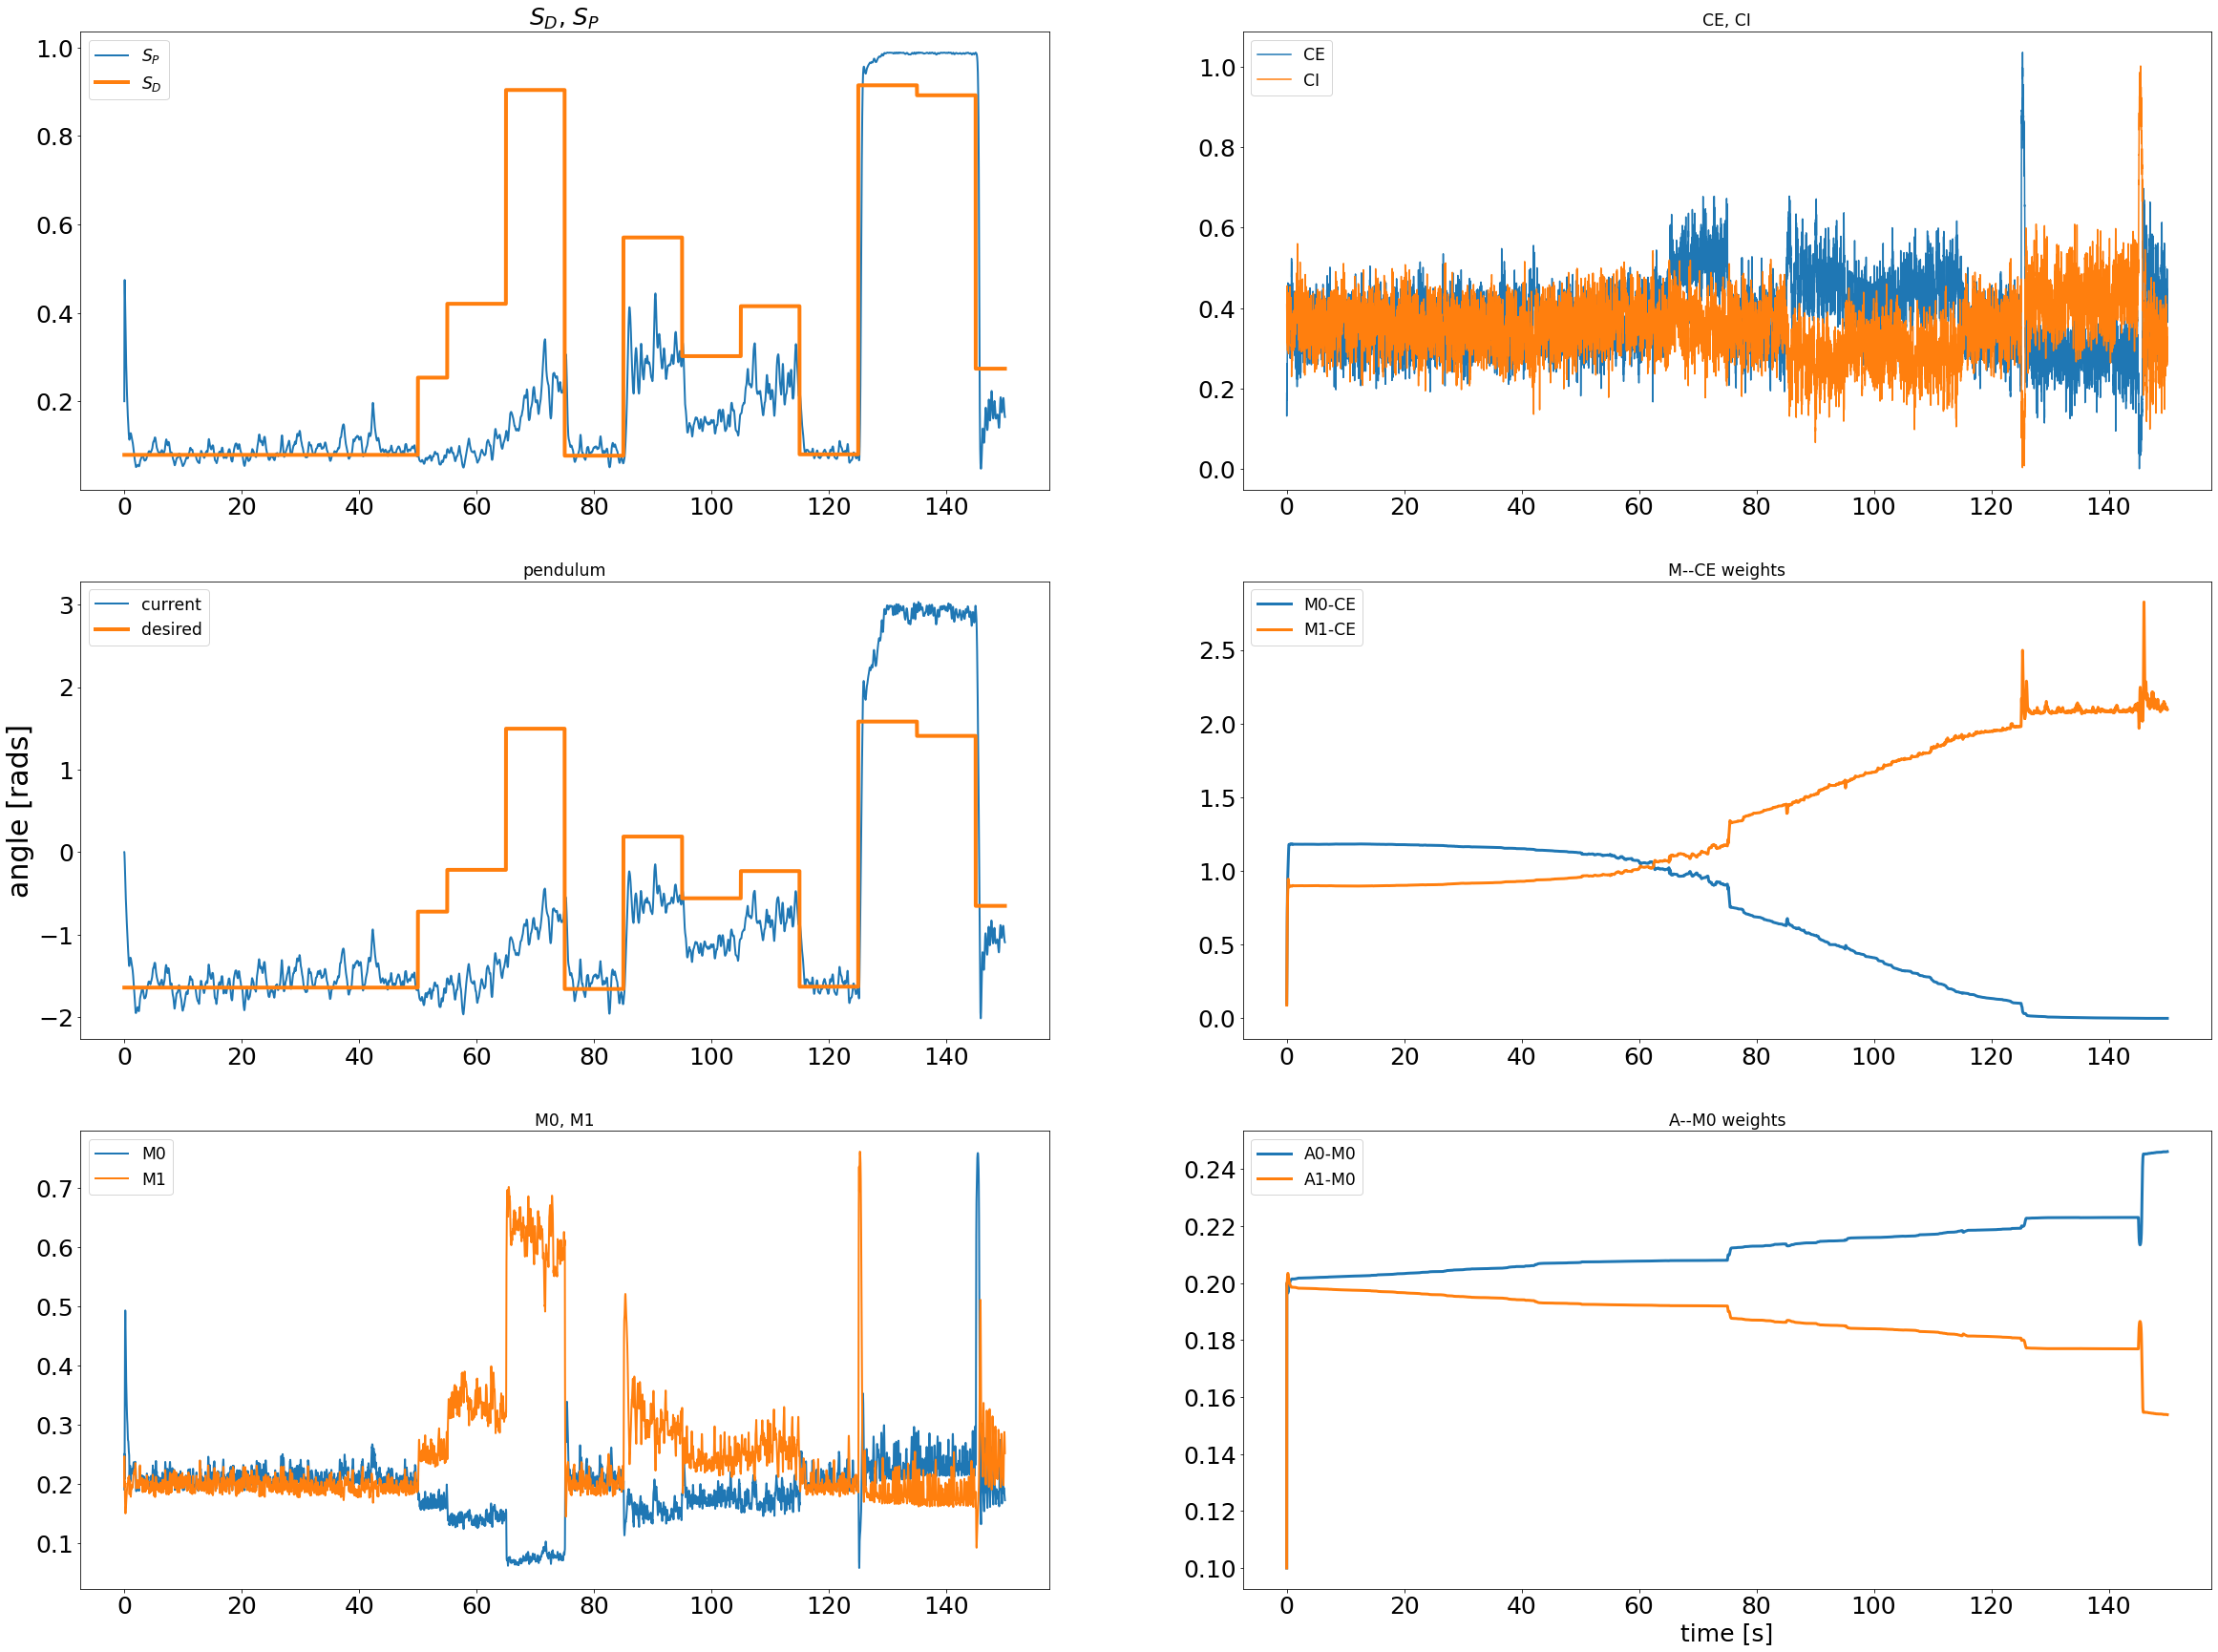

In [11]:
# A figure with more formatting

res_fig, res_axs = plt.subplots(3,2, figsize=(40, 30))

for ax in res_axs.flatten(): 
    ax.tick_params(axis='both', labelsize=25)

SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
ax = res_axs[0,0]
ax.plot(times, SF_data[0,:].transpose(), label='$S_P$', linewidth=2)
ax.plot(times, SP_data[0,:].transpose(), label='$S_D$', linewidth=4)
ax.legend(['$S_P$', '$S_D$'], fontsize='xx-large')
ax.set_title('$S_D$, $S_P$', fontsize='25')


P_data = plant_data[P]
ax = res_axs[1,0]
ax.plot(times, P_data[:,0], linewidth=2)
#plt.plot(times, P_data[:,1], label='ang vel')
#desa_data = des_angs[(times/pres_interv).astype(int)]
#desa_data1 
idx1 = int(sim_time1/net.min_delay)
desa_data = des_angs[1+((times[idx1:]-pres_interv2/2)/pres_interv2).astype(int)] # 2 stages
ax.plot(times, np.concatenate((des_angs[0]*np.ones(idx1), desa_data)), linewidth=4)
#ax.plot(times, desa_data, linewidth=4)
ax.legend(['current', 'desired'], fontsize='xx-large')
ax.set_title('pendulum', fontsize='xx-large')
ax.set_ylabel('angle [rads]', fontsize=30)


M_data = np.array(data[M])
ax = res_axs[2,0]
ax.plot(times, M_data.transpose(), linewidth=2)
ax.legend(['M0', 'M1'], fontsize='xx-large')
ax.set_title('M0, M1', fontsize='xx-large')

C0_data = np.array(data[C[0]])
C1_data = np.array(data[C[1]])
ax = res_axs[0,1]
ax.plot(times, C0_data.transpose(), times, C1_data.transpose())
ax.legend(['CE', 'CI'], fontsize='xx-large')
ax.set_title('CE, CI', fontsize='xx-large')

w_track_data = np.array(data[M_C0_track])
ax = res_axs[1,1]
ax.plot(times, w_track_data.transpose(), linewidth=3)
ax.legend(['M0-CE', 'M1-CE'], fontsize='xx-large')
ax.set_title('M--CE weights', fontsize='xx-large')

w_track_data2 = np.array(data[A_M0_track])
ax = res_axs[2,1]
ax.plot(times, w_track_data2.transpose(), linewidth=3)
ax.legend(['A0-M0', 'A1-M0'], fontsize='xx-large')
ax.set_title('A--M0 weights', fontsize='xx-large')
ax.set_xlabel('time [s]', fontsize=25)

plt.show()

Text(0.5, 1.0, 'SPF')

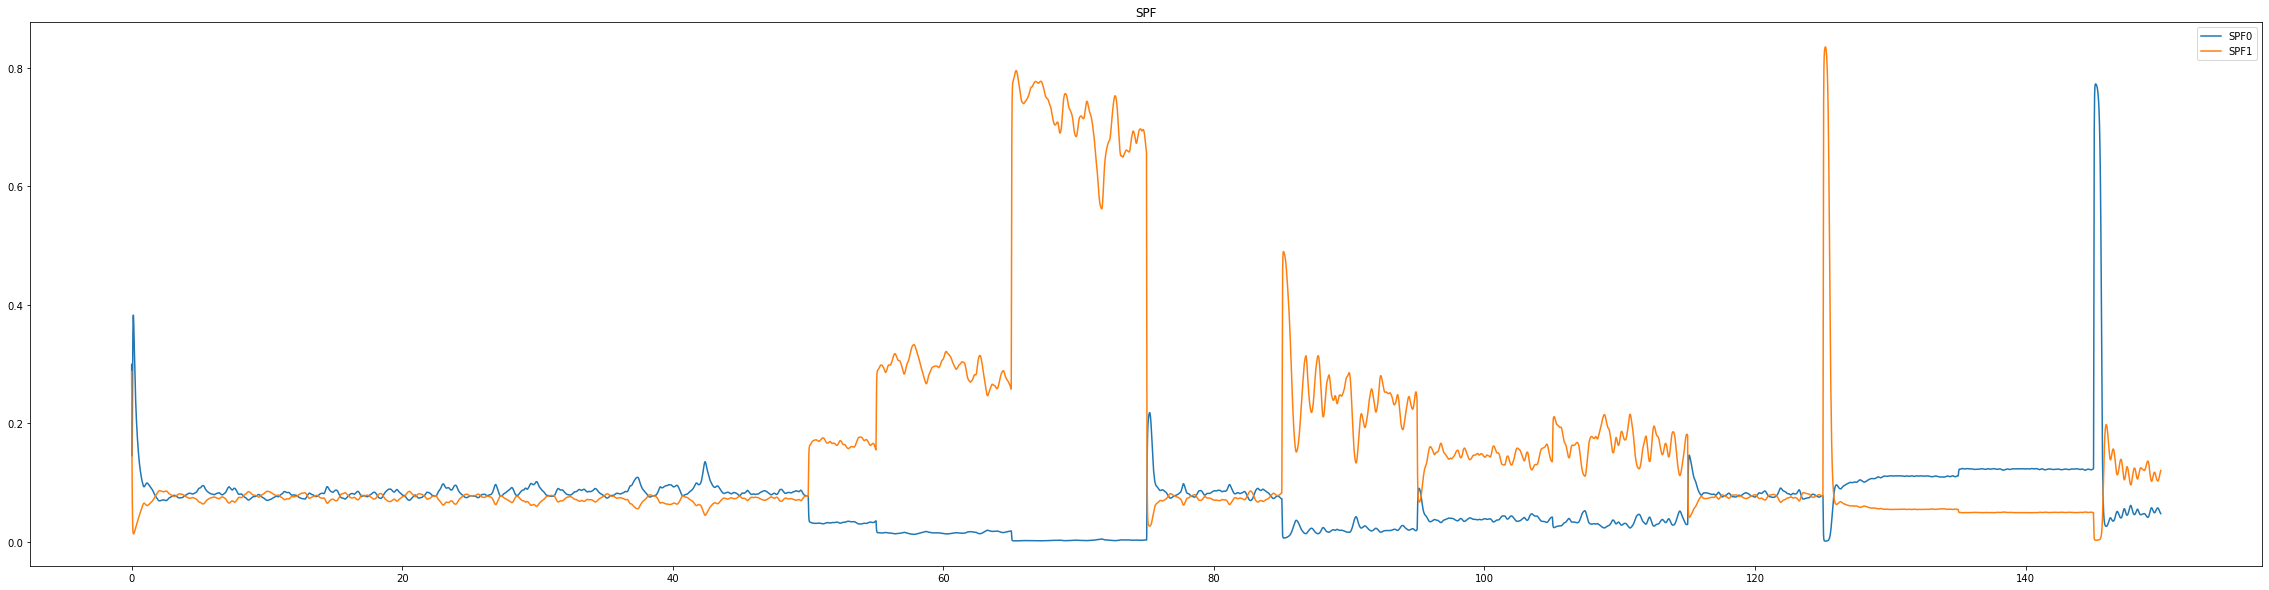

In [13]:
# SPF
fs = (40, 10)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')

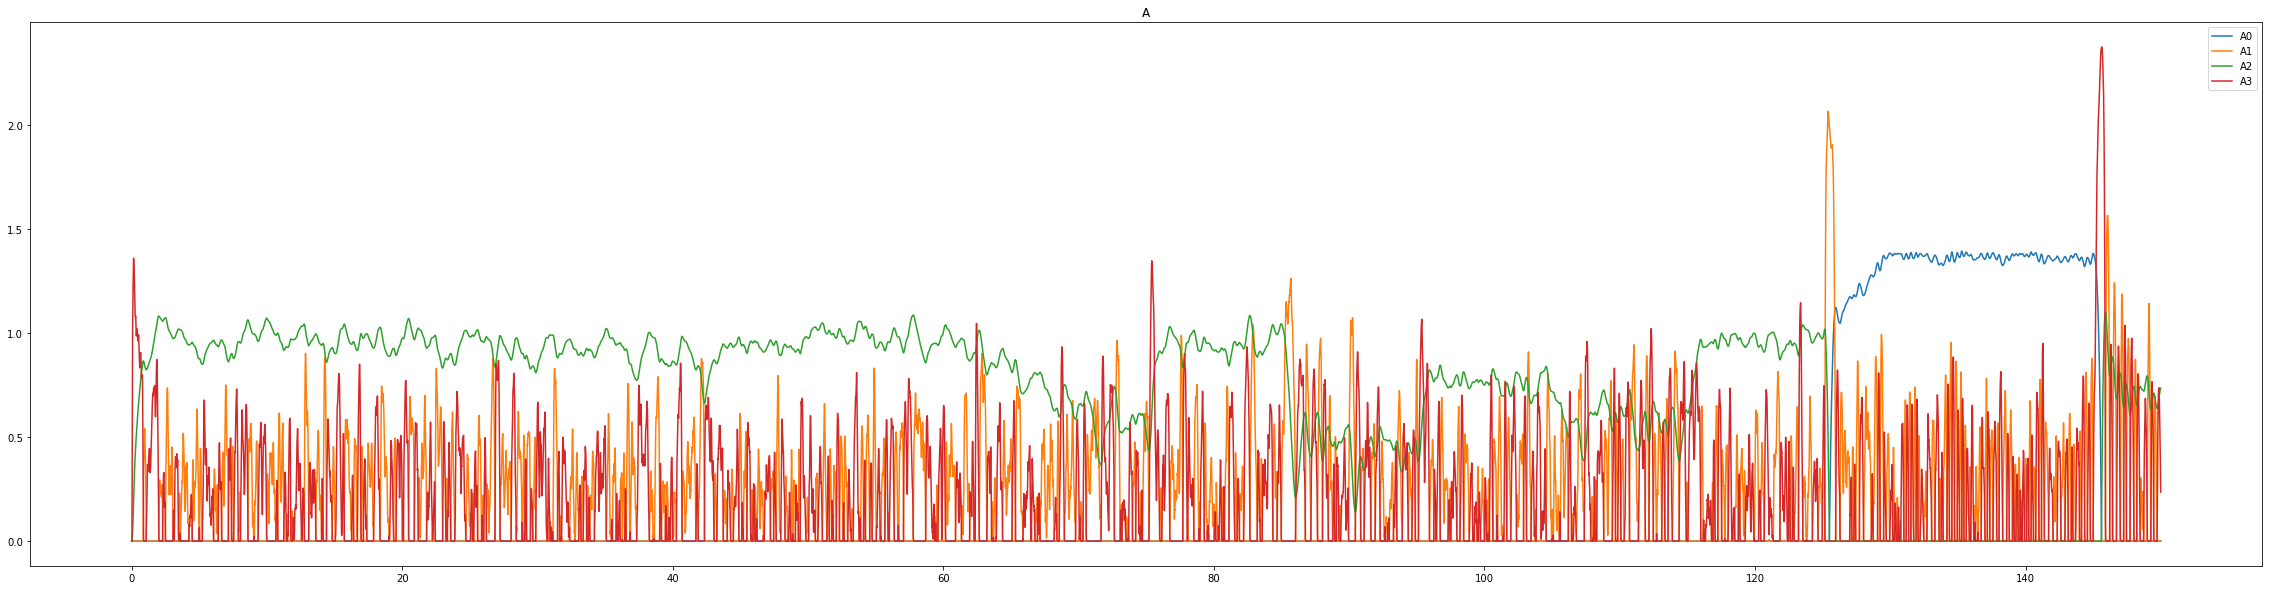

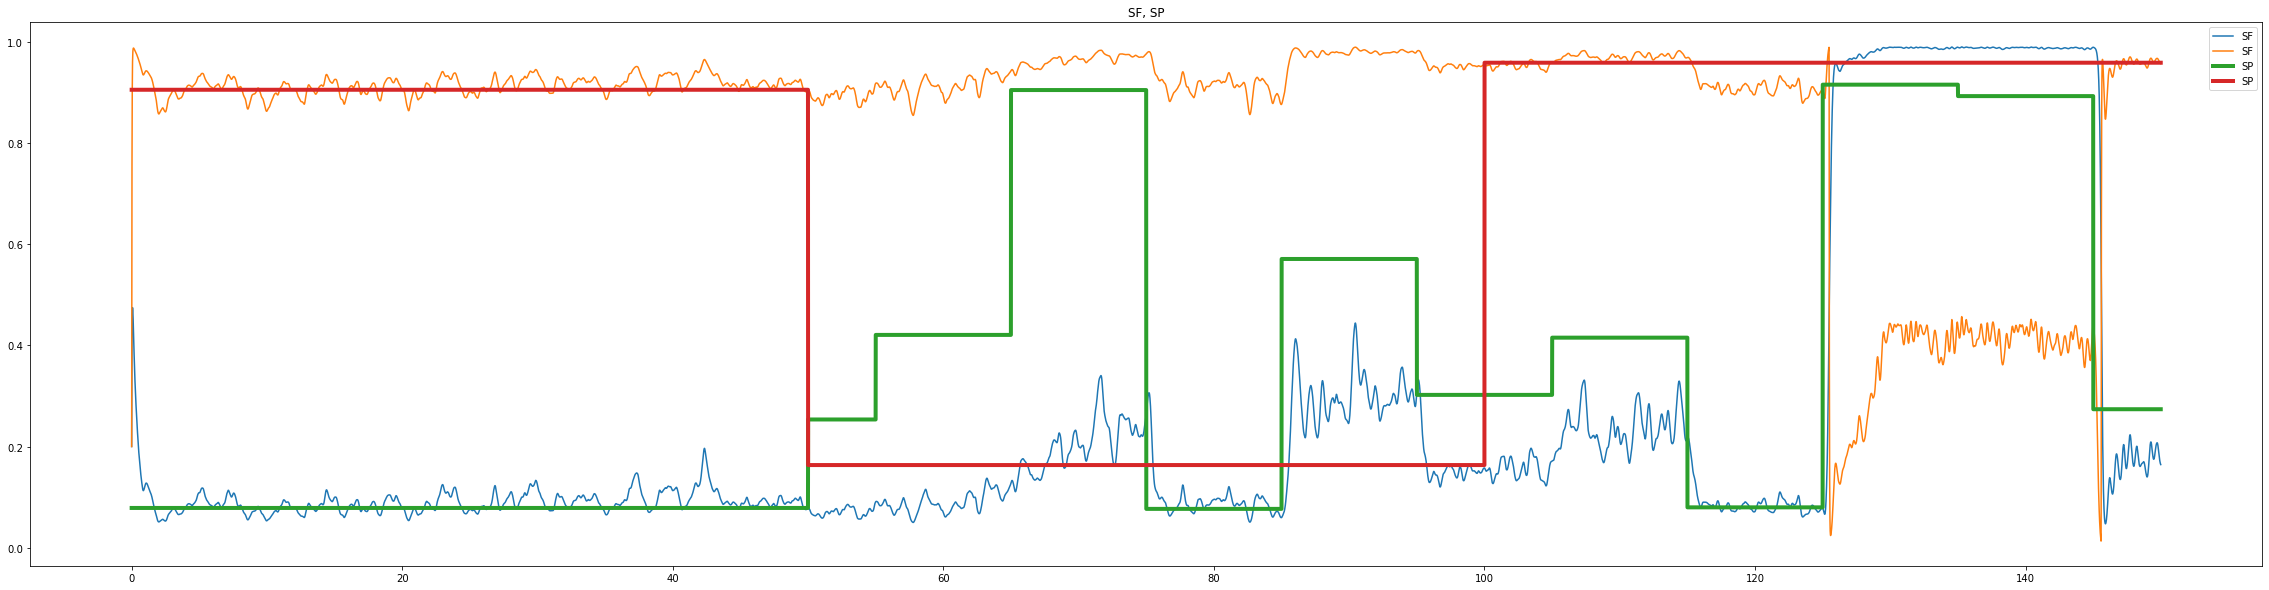

Text(0.5, 1.0, 'A--M0 weights')

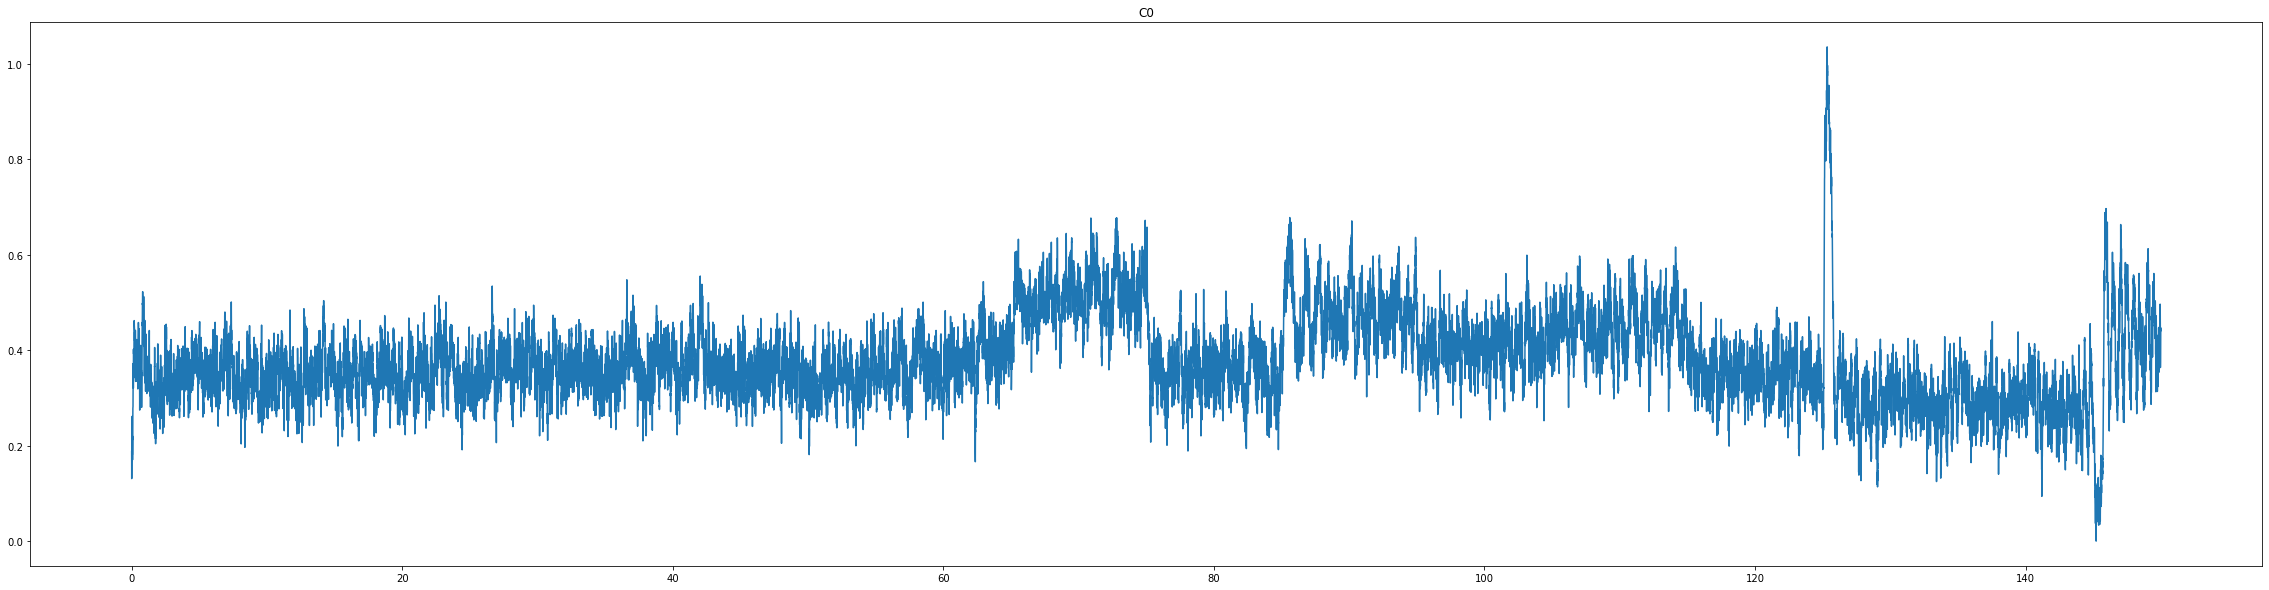

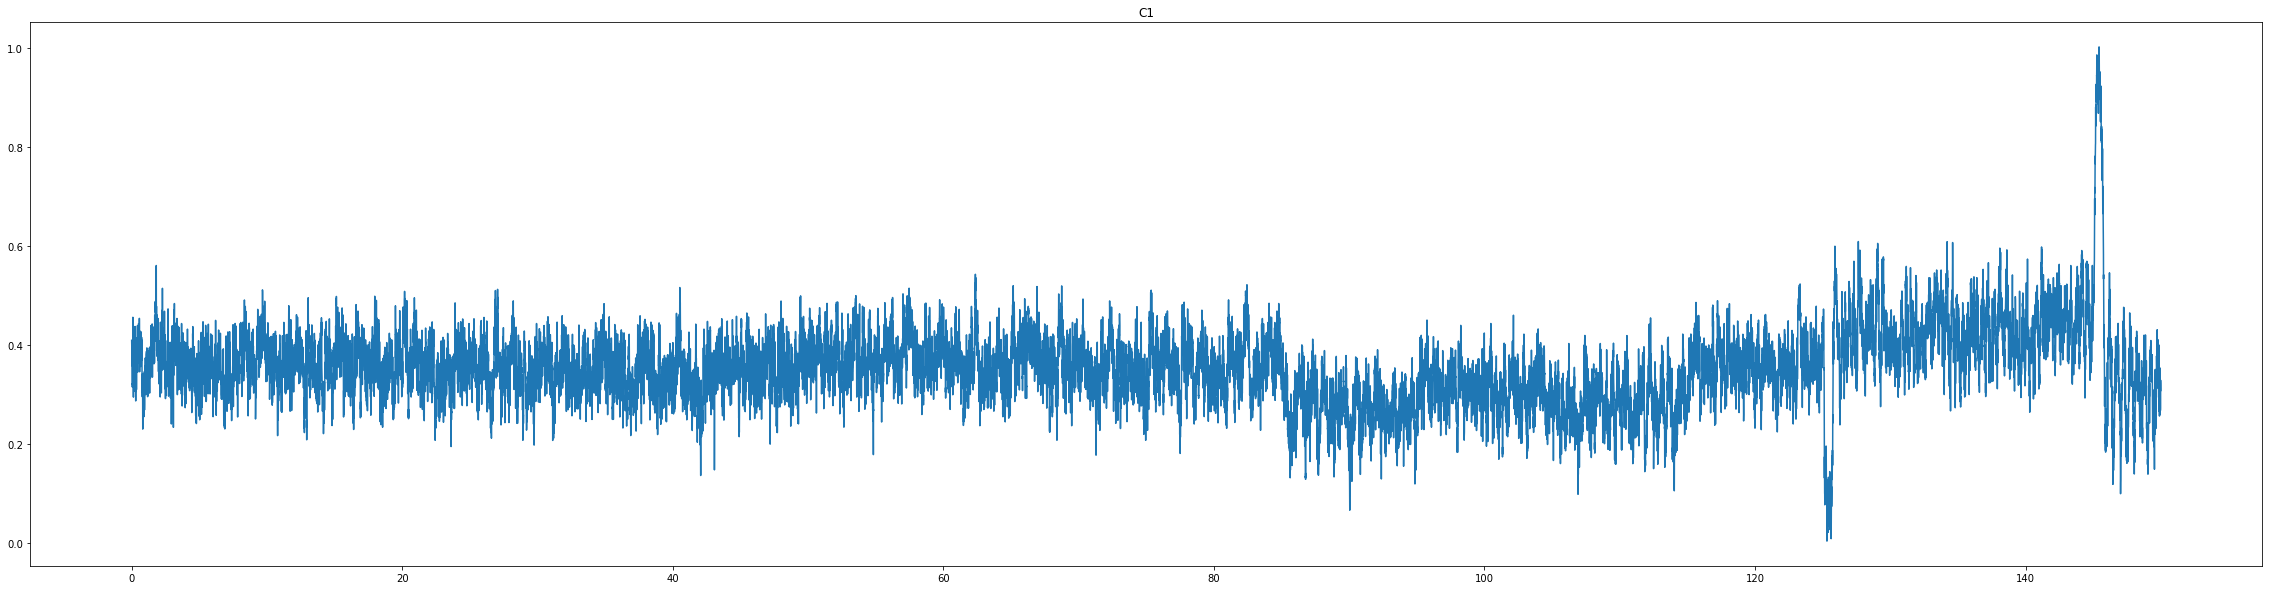

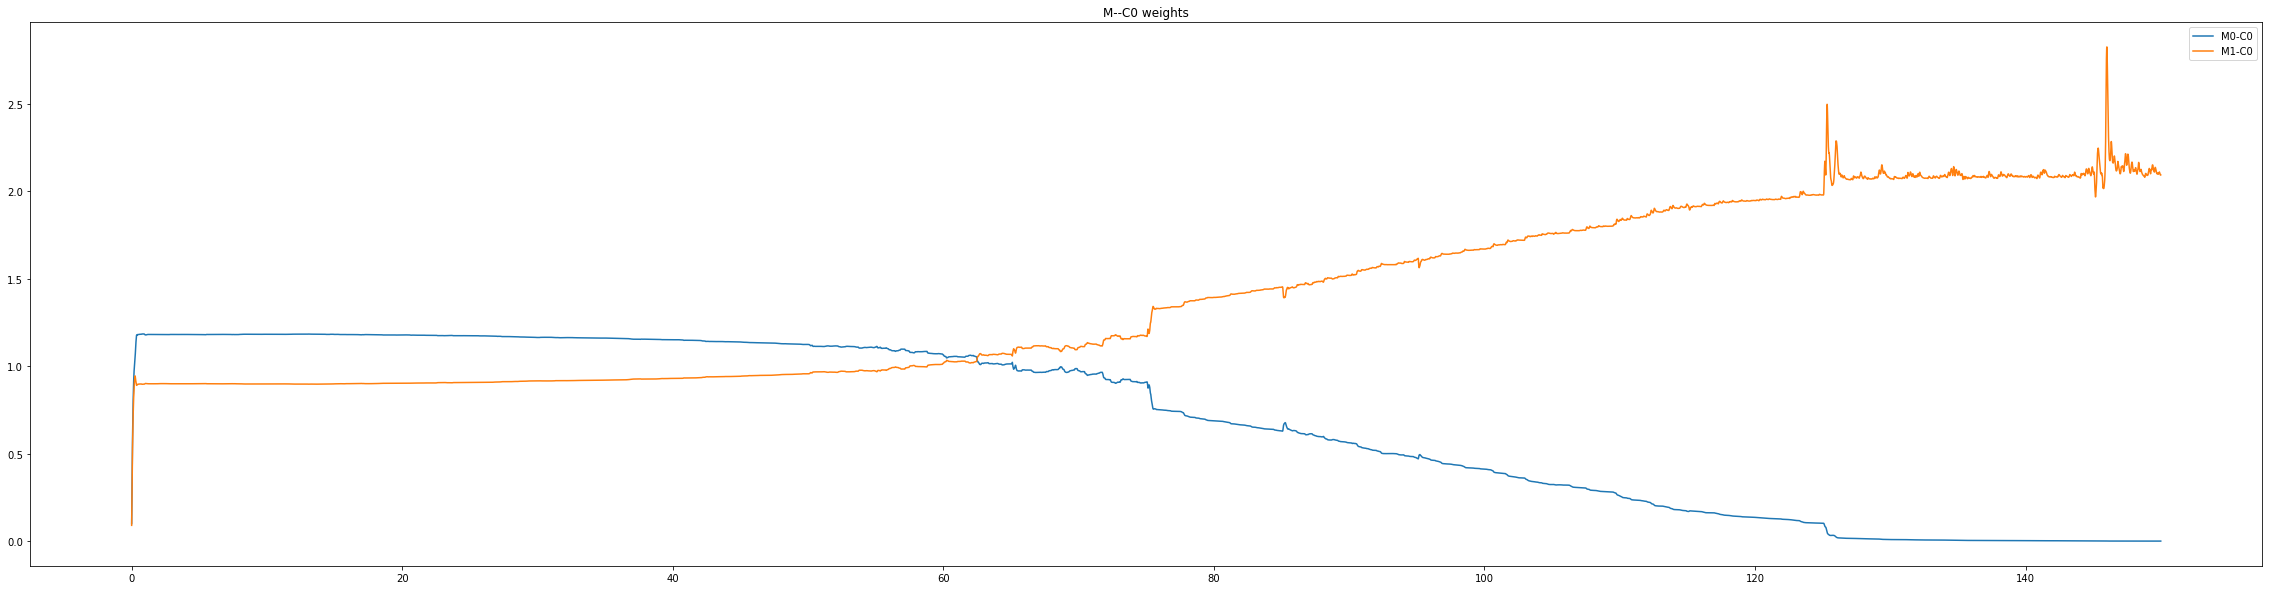

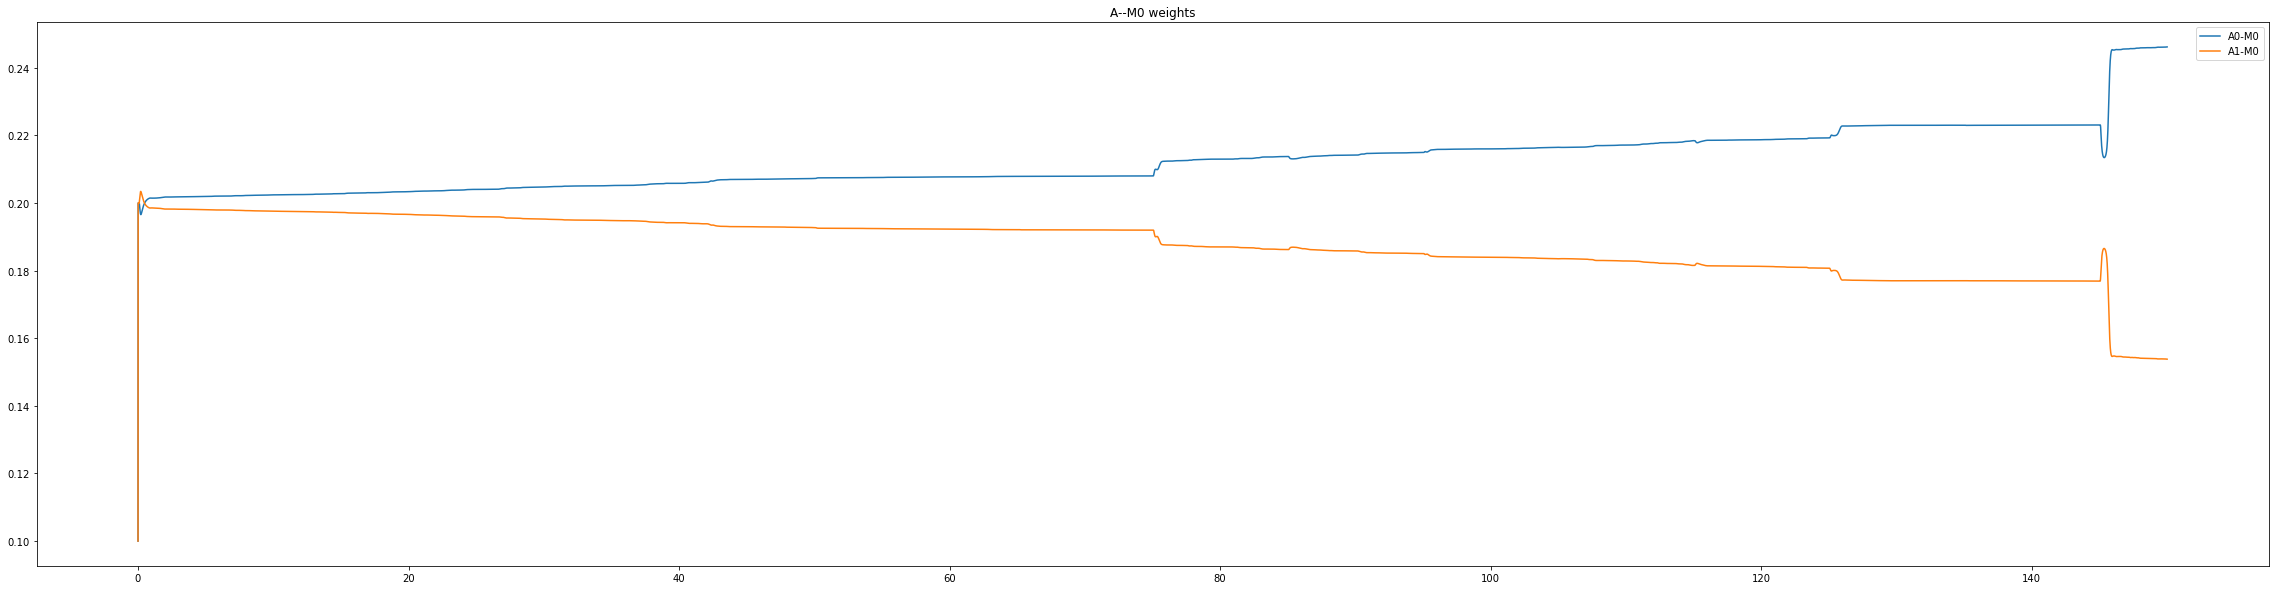

In [8]:
# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
#print(A_data[:,-1])

# L
# L_fig = plt.figure(figsize=fs)
# L_data = np.array(data[L])
# plt.plot(times, L_data.transpose())
# plt.title('L')

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP', linewidth=4)
plt.legend()
plt.title('SF, SP')
plt.show()
#print('SF = [%f]' % (SF_data[0,-1]))
#print('SP = [%f]' % (SP_data[0,-1]))


# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
#plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
#print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
#plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
#print(C1_data[-1])

# M--C0 weights
W_fig1 = plt.figure(figsize=fs)
w_track_data = np.array(data[M_C0_track])
plt.plot(times, w_track_data.transpose())
plt.legend(['M0-C0', 'M1-C0'])
plt.title('M--C0 weights')

# A--M0 weights
W_fig2 = plt.figure(figsize=fs)
w_track_data2 = np.array(data[A_M0_track])
plt.plot(times, w_track_data2.transpose())
plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
plt.title('A--M0 weights')


In [19]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=500*200
second_idx=600*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [24]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

---